In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [48]:
(train_data, test_data), info = tfds.load('mnist', 
                                          split=['train', 'test'],
                                          as_supervised=True,
                                          shuffle_files=True,
                                          with_info=True,
                                          )

In [49]:
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [50]:
len(train_data)

60000

In [51]:
len(test_data)

10000

In [52]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [53]:
class_names = info.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [54]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [55]:
for image, label in train_one_sample:
  print(f"""
  the Image shape is {image.shape},
  the image datatype {image.dtype},
  the target class {label},
  """)


  the Image shape is (28, 28, 1),
  the image datatype <dtype: 'uint8'>,
  the target class 4,
  


In [56]:
image

<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],


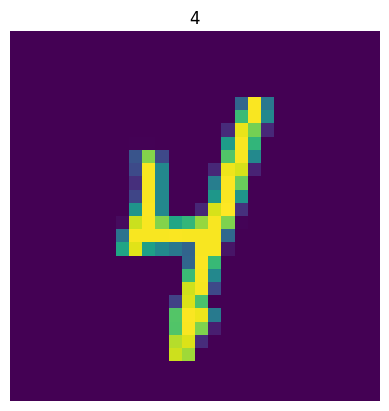

In [57]:
import matplotlib.pyplot as plt

def show_image(image, label):
  plt.imshow(image)
  plt.title(int(label))
  plt.axis(False);

show_image(image, label)

# working with 20% of the data for experiment

In [58]:
import numpy as np

train_data_20_percent = train_data.take(tf.cast(0.2 * len(train_data), tf.int32).numpy())
len(train_data_20_percent)

12000

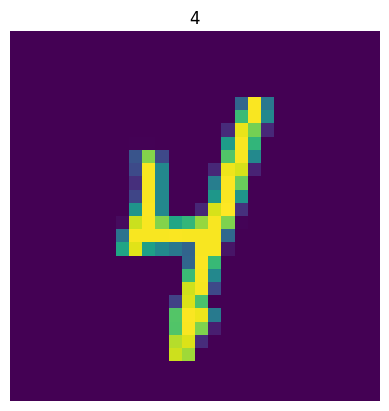

In [59]:
one_sample = train_data_20_percent.take(1)
image, label = next(one_sample.as_numpy_iterator())

show_image(image, label)

In [60]:
def preprocess_image(image, label, img_shape=224):
  image = tf.image.resize(image, [28, 28])
  return tf.cast(image, tf.float32), label


## Spliting the 20 percent data into 80 training and 20 percent validation

In [61]:
len(train_data_20_percent)

12000

In [62]:
train_size = tf.cast(0.8 * len(train_data_20_percent), tf.int32).numpy()
valid_size = tf.cast(0.2 * len(train_data_20_percent), tf.int32).numpy()
train_data_20_percent_80_training = train_data_20_percent.take(train_size)
train_data_20_percent_20_validation = train_data_20_percent.skip(train_size).take(valid_size)

In [63]:
len(train_data_20_percent_80_training), len(train_data_20_percent_20_validation)

(9600, 2400)

## Batch and prepare our data

In [64]:
# map the training portion
train_data_20_percent_80_training = train_data_20_percent_80_training.map(preprocess_image,  num_parallel_calls=tf.data.AUTOTUNE)

train_data_20_percent_80_training = train_data_20_percent_80_training.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map the test portion

train_data_20_percent_20_validation = train_data_20_percent_20_validation.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



In [65]:
# from tensorflow.keras import mixed_precision

# mixed_precision.set_global_policy("mixed_float16")

# Building the model

In [66]:
tensorboard_path = "tensorboard/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [67]:
len(train_data_20_percent_80_training)

300

In [68]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
 
 
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_data_20_percent_80_training,
                    epochs=100,
                    steps_per_epoch=len(train_data_20_percent_80_training),
                    validation_data=train_data_20_percent_20_validation,
                    validation_steps=len(train_data_20_percent_20_validation),
                    callbacks=[tensorboard_callback, early_stopping_callback]
                    )

Epoch 1/100
300/300 [==============================] - 6s 14ms/step - loss: 0.8181 - accuracy: 0.7309 - val_loss: 0.2597 - val_accuracy: 0.9187
Epoch 2/100
300/300 [==============================] - 3s 11ms/step - loss: 0.2314 - accuracy: 0.9320 - val_loss: 0.1757 - val_accuracy: 0.9458
Epoch 3/100
300/300 [==============================] - 3s 9ms/step - loss: 0.1684 - accuracy: 0.9509 - val_loss: 0.1502 - val_accuracy: 0.9592
Epoch 4/100
300/300 [==============================] - 3s 10ms/step - loss: 0.1364 - accuracy: 0.9593 - val_loss: 0.1252 - val_accuracy: 0.9638
Epoch 5/100
300/300 [==============================] - 4s 12ms/step - loss: 0.1134 - accuracy: 0.9651 - val_loss: 0.1276 - val_accuracy: 0.9633
Epoch 6/100
300/300 [==============================] - 3s 11ms/step - loss: 0.0998 - accuracy: 0.9709 - val_loss: 0.1145 - val_accuracy: 0.9675
Epoch 7/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0890 - accuracy: 0.9742 - val_loss: 0.1241 - val_accuracy: 0

<Axes: >

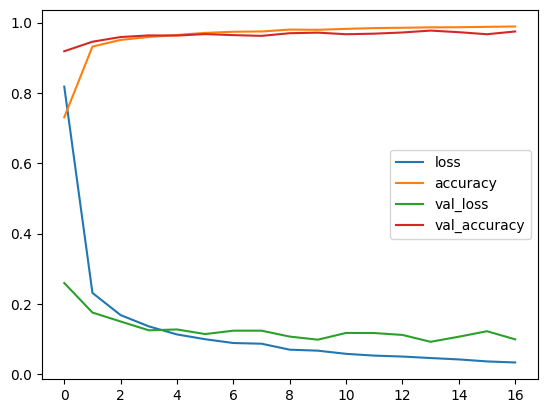

In [69]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [70]:
len(train_data)

60000

In [71]:
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [72]:
tensorboard_path = "tensorboard/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [73]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
 
 
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(160, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

full_history = model.fit(train_data,
                    epochs=100,
                    callbacks=[tensorboard_callback, early_stopping_callback]
                    )

Epoch 1/100
1875/1875 [==============================] - 16s 7ms/step - loss: 0.1869 - accuracy: 0.9432
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0624 - accuracy: 0.9805
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0450 - accuracy: 0.9861
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0353 - accuracy: 0.9888
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0295 - accuracy: 0.9907
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0251 - accuracy: 0.9923
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0209 - accuracy: 0.9932
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0178 - accuracy: 0.9942
Epoch 9/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0161 - accuracy: 0.9950
Epoch 10/100
1875/1875 [==============================] - 9s 5ms/step - 

<Axes: >

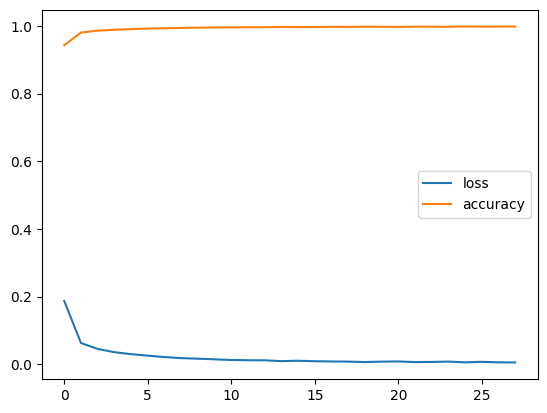

In [74]:
import pandas as pd

pd.DataFrame(full_history.history).plot()